### **Environment Setup**

In [ ]:
# Install libraries
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade pandas matplotlib seaborn scikit-learn mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.23.3
    Uninstalling mlxtend-0.23

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

from mlxtend.frequent_patterns import apriori, association_rules

from google.cloud import bigquery
from google.oauth2 import service_account


### **Connect to BigQuery**

In [ ]:
# Connect to BigQuery

credentials = service_account.Credentials.from_service_account_file('/content/online-retail-dwdm-457717-28a7cf8905bb.json')

project_id = 'online-retail-dwdm-457717'  # GCP project ID
client = bigquery.Client(credentials=credentials, project=project_id)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Data Preparation (Customer Summaries)**
#### **Get Data from BigQuery**

In [ ]:
# Query to fetch customer summary
query = """
SELECT
  CustomerID,
  COUNT(DISTINCT InvoiceNo) AS NumberOfPurchases,
  SUM(TotalPrice) AS TotalSpent
FROM
  `online-retail-dwdm-457717.online_retail.data`
GROUP BY
  CustomerID
"""
customer_summary = client.query(query).to_dataframe()

# Check
customer_summary.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CustomerID,NumberOfPurchases,TotalSpent
0,17811,47,9603.10
1,17290,8,1440.96
2,16891,11,2056.82
3,12748,322,52194.26
4,14104,5,768.58


### **Preprocessing for Clustering**

In [ ]:
# Handle missing values if any
customer_summary.dropna(inplace=True)

# Features for clustering
X = customer_summary[['NumberOfPurchases', 'TotalSpent']]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Clustering**
#### **Find Optimal Clusters Using Elbow Method**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



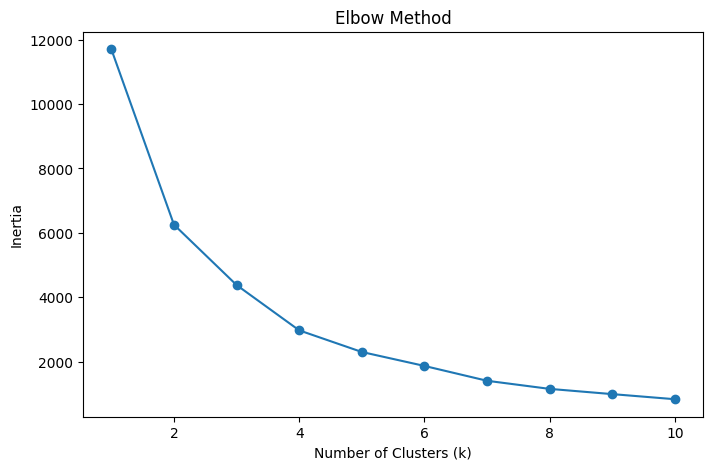

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### **4.1 Apply K-Means Clustering**

In [ ]:
# Apply KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
customer_summary['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Compute original‐unit centroids
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(centers, columns=['NumberOfPurchases','TotalSpent'])
cluster_centers['Cluster'] = cluster_centers.index



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



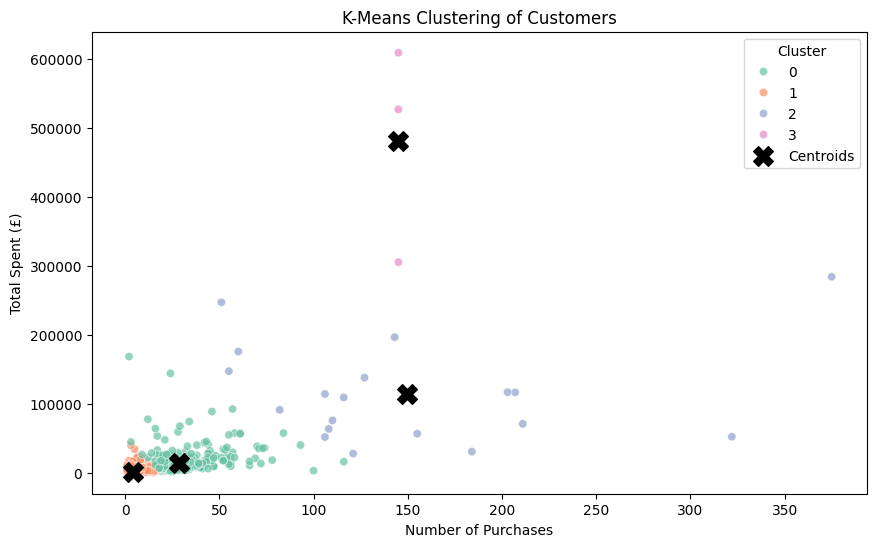

In [ ]:
# Plot the clusters with centroids
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=customer_summary,
    x='NumberOfPurchases',
    y='TotalSpent',
    hue='KMeans_Cluster',
    palette='Set2',
    alpha=0.7
)
plt.scatter(
    cluster_centers['NumberOfPurchases'],
    cluster_centers['TotalSpent'],
    marker='X',
    s=200,
    c='black',
    label='Centroids'
)
plt.title('K-Means Clustering of Customers')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spent (£)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Cluster stats
cluster_stats = (
    customer_summary
    .groupby('KMeans_Cluster')
    .agg(
        ClusterSize=('CustomerID','count'),
        AvgPurchases=('NumberOfPurchases','mean'),
        AvgSpent=('TotalSpent','mean')
    )
    .reset_index()
    .rename(columns={'KMeans_Cluster':'Cluster'})
)

# Display the cluster statistics table
display(cluster_stats)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Cluster,ClusterSize,AvgPurchases,AvgSpent
0,0,401,28.476309,14783.489975
1,1,5430,4.03628,1457.566731
2,2,19,149.578947,113928.902632
3,3,3,145.0,480267.266667


***Cluster 1 (“Casual Buyers”)***

5,430 customers, average 4 purchases and £1,457 spent.

This is the core of our customer base—steady but low spenders.

***Cluster 0 (“Frequent Mid-Range Shoppers”)***

401 customers, average 28 purchases and £14,783 spent.

Highly engaged shoppers, good candidates for loyalty programs.

***Cluster 2 (“High-Value Customers”)***

19 customers, average 150 purchases and £113,929 spent.

Top-tier segment—likely corporate or repeat bulk buyers. Offer exclusive VIP treatment.

***Cluster 3 (“Ultra-High Spenders”)***

3 customers, average 145 purchases and £480,267 spent.

These are your biggest whales—focus on personalized white-glove service and bespoke offers.

***Key Insight for Stakeholders
We’ve divided the customer base into four clear tiers:***

A large group of casual buyers on modest spending.

A smaller cadre of mid-range shoppers with frequent moderate purchases.

A tiny but lucrative group of high-value and ultra-high spenders who account for a disproportionate share of revenue.

*Actionable Recommendations:*

**Cluster 1: Engage with targeted promotions to boost their average spend.**

**Cluster 0: Reward their loyalty with tiered incentives.**

**Cluster 2 & 3: Design a VIP program with exclusive perks to maintain and grow their high-value relationship.**

### **DBSCAN Clustering**

In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_summary['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



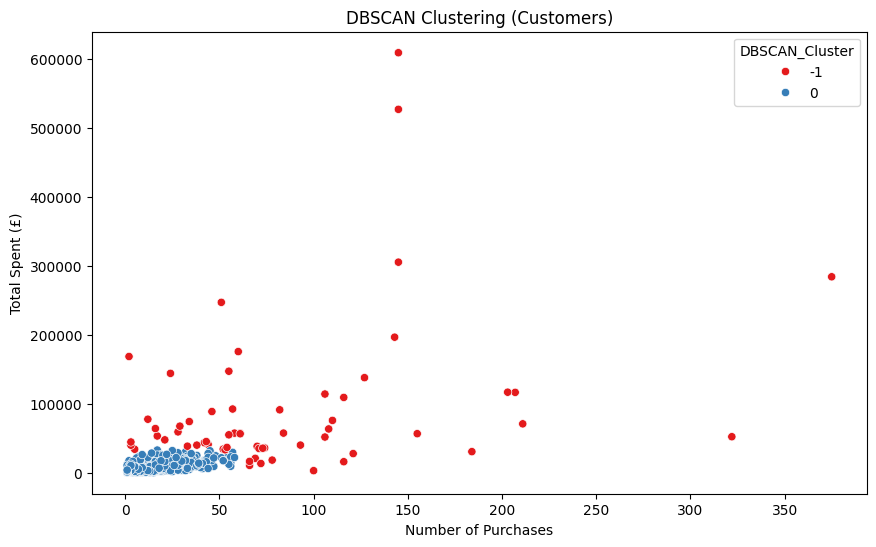

In [ ]:
# Plot DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='NumberOfPurchases',
    y='TotalSpent',
    hue='DBSCAN_Cluster',
    palette='Set1',
    data=customer_summary,
    legend='full'
)
plt.title('DBSCAN Clustering (Customers)')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spent (£)')
plt.show()

In [ ]:
# Cluster statistics
cluster_stats = customer_summary.groupby('DBSCAN_Cluster').agg(
    Customers=('CustomerID', 'count'),
    AvgPurchases=('NumberOfPurchases', 'mean'),
    AvgSpent=('TotalSpent', 'mean')
).reset_index()

print(cluster_stats.to_string(index=False))

 DBSCAN_Cluster  Customers  AvgPurchases     AvgSpent
             -1         61     85.245902 90822.803115
              0       5792      5.423515  2055.943852


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



***Insights from the Output:***

* **-1**: These customers are outliers. They may be big spenders who bought significantly more than average.

*  **0**: This is the main cluster, representing the bulk of customers **who buy a few items and spend around £2055**



```
# This is formatted as code
```

### **Association Rule Mining (Apriori)**
#### **Query InvoiceNo and ProductName**

In [ ]:
try:
    query = """
    SELECT
      InvoiceNo,
      ProductName
    FROM
      `online-retail-dwdm-457717.online_retail.data`
    WHERE
      InvoiceNo IS NOT NULL
      AND ProductName IS NOT NULL
      AND LENGTH(ProductName) > 3
    LIMIT 50000
    """
    transactions = client.query(query).to_dataframe()
    print(f"Query successful, rows fetched: {len(transactions)}")
    display(transactions.head())
except Exception as e:
    print("Error fetching data from BigQuery:", e)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



✅ Query successful, rows fetched: 50000


,InvoiceNo,ProductName
0,523773,JACOBS LADDER SMALL
1,510801,JACOBS LADDER SMALL
2,490279,JACOBS LADDER SMALL
3,578757,LETTER SHAPE PENCIL SHARPENER
4,558198,PORCELAIN BUDAH INCENSE HOLDER


### **Create Basket Matrix (Invoice × ProductName)**

In [ ]:
try:
    basket = transactions.groupby(['InvoiceNo', 'ProductName']).size()
    .unstack(fill_value=0)
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)
    print(f"Basket created: {basket.shape[0]} transactions ×
    {basket.shape[1]} products")
    display(basket.head())
except Exception as e:
    print("Error creating basket:", e)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-27-39cddb1d8852>:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



✅ Basket created: 7500 transactions × 1843 products


ProductName,4 PURPLE FLOCK DINNER CANDLES,CAMPHOR WOOD PORTOBELLO MUSHROOM,DOLLY GIRL BEAKER,IVORY PAPER CUP CAKE CASES,RED SPOT GIFT BAG LARGE,STAR T-LIGHT HOLDER,VINTAGE DESIGN GIFT TAGS,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,...,YELLOW/PINK FLOWER DESIGN BIG MUG,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEARTS PLANT POT HOLDER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC T-LIGHT HOLDER STAR LARGE,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
489488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Apply Apriori Algorithm**

In [ ]:
try:
    frequent_itemsets = apriori(basket, min_support=0.008, use_colnames=True)
    print(f"Frequent itemsets found: {len(frequent_itemsets)}")
    display(frequent_itemsets.sort_values('support', ascending=False).head(10))
except Exception as e:
    print("Error during apriori algorithm:", e)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



✅ Frequent itemsets found: 263


,support,itemsets
135,0.139733,(REX CASH+CARRY JUMBO SHOPPER)
16,0.050667,(60 TEATIME FAIRY CAKE CASES)
17,0.046133,(72 SWEETHEART FAIRY CAKE CASES)
114,0.044933,(PACK OF 60 PINK PAISLEY CAKE CASES)
112,0.043467,(PACK OF 60 DINOSAUR CAKE CASES)
118,0.038667,(PACK OF 72 SKULL CAKE CASES)
117,0.036800,(PACK OF 72 RETROSPOT CAKE CASES)
115,0.036000,(PACK OF 60 SPACEBOY CAKE CASES)
113,0.034667,(PACK OF 60 MUSHROOM CAKE CASES)
23,0.032667,(BATHROOM METAL SIGN)


### **Apriori Analysis Results**

## Understanding the Output

The table shows the top 10 most frequently purchased individual items from our dataset, sorted by their "support" values:

### What Support Values Mean

- **Support value**: This number represents how frequently an item appears in all transactions. For example, "REX CASH+CARRY JUMBO SHOPPER" has a support of 0.139733, meaning it appears in about 14% of all transactions.

## Key Insights from Frequent Itemsets

### 1. Shopping Bags are Top Sellers
- The most frequently purchased item is a shopping bag/carrier (REX CASH+CARRY JUMBO SHOPPER), appearing in nearly 14% of transactions.

### 2. Cake Cases are Popular
- Most top items are various cake cases with different designs (fairy, pink paisley, dinosaur, skull, etc.), indicating this is likely a store selling baking supplies.

### 3. Product Diversification
- While cake cases dominate, there's at least one non-baking item (BATHROOM METAL SIGN) among the top items.

### 4. Popular Designs
- Customers seem to prefer certain designs - "TEATIME FAIRY" cake cases appear in about 5% of transactions compared to "SKULL" designs at around 3.9%.

### Business Implications
These findings can help guide inventory management, marketing focus, and store layout decisions by identifying the most commonly purchased items.

### **Generate Association Rules**

In [ ]:
try:
    rules = association_rules(frequent_itemsets, metric="lift",
                              min_threshold=1)
    print(f"Association rules generated: {len(rules)}")
    display(rules.sort_values('lift', ascending=False).head(10))
except Exception as e:
    print("Error generating association rules:", e)


✅ Association rules generated: 142


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
51,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.008800,0.008133,0.008000,0.909091,111.773472,1.0,0.007928,10.910533,0.999852,0.895522,0.908345,0.946349
50,(HERB MARKER ROSEMARY),(HERB MARKER PARSLEY),0.008133,0.008800,0.008000,0.983607,111.773472,1.0,0.007928,60.463200,0.999180,0.895522,0.983461,0.946349
52,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.008667,0.008800,0.008133,0.938462,106.643357,1.0,0.008057,16.107000,0.999283,0.871429,0.937915,0.931352
53,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.008800,0.008667,0.008133,0.924242,106.643357,1.0,0.008057,13.085600,0.999418,0.871429,0.923580,0.931352
46,(HERB MARKER MINT),(HERB MARKER PARSLEY),0.008933,0.008800,0.008133,0.910448,103.459973,1.0,0.008055,11.068400,0.999261,0.847222,0.909653,0.917345
47,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.008800,0.008933,0.008133,0.924242,103.459973,1.0,0.008055,13.082080,0.999127,0.847222,0.923560,0.917345
48,(HERB MARKER THYME),(HERB MARKER MINT),0.008667,0.008933,0.008000,0.923077,103.329506,1.0,0.007923,12.883867,0.998980,0.833333,0.922384,0.909300
49,(HERB MARKER MINT),(HERB MARKER THYME),0.008933,0.008667,0.008000,0.895522,103.329506,1.0,0.007923,9.488476,0.999249,0.833333,0.894609,0.909300
42,(CHILDS GARDEN TROWEL PINK),(CHILDS GARDEN FORK PINK),0.010667,0.011067,0.008267,0.775000,70.030120,1.0,0.008149,4.395259,0.996348,0.613861,0.772482,0.760994
43,(CHILDS GARDEN FORK PINK),(CHILDS GARDEN TROWEL PINK),0.011067,0.010667,0.008267,0.746988,70.030120,1.0,0.008149,3.910222,0.996751,0.613861,0.744260,0.760994


### **Product Association Analysis**

## Overview
This table shows the strongest relationships between items purchased together in your store. The analysis reveals which products are frequently bought in combination.

## Key Insights

### Strong Herb Marker Associations
- There's an extremely strong relationship between different herb markers (Parsley, Rosemary, Thyme, Mint)
- When a customer buys one herb marker, they're very likely to buy another

### Particularly High Lift Values
- The lift values over 100 for herb marker combinations indicate these items are purchased together far more frequently than would happen by random chance
- For example: someone buying a Parsley herb marker is 111.7 times more likely to buy a Rosemary herb marker than a random customer

### Garden Tool Sets
- The pink children's garden tools (fork and trowel) show strong association (lift of 70)
- Suggests customers tend to buy these as matching sets

### High Confidence Values
- Confidence values mostly above 0.9 for herb markers
- Indicates 90%+ probability customers will buy the paired item if they purchase one

### Complementary Product Strategy
- These associations reveal natural product pairings that customers already recognize as belonging together

## Business Applications

### Product Bundling
- Consider bundling herb markers as sets to match existing purchase patterns

### Product Placement
- Keep complementary items displayed together (especially herb markers)

### Promotional Strategies
- Create special offers on complementary items to increase average transaction value

### Staff Training
- Train staff to suggest the complementary items identified in these rules

## Conclusion
This analysis helps optimize product placement, bundling strategies, and cross-selling opportunities.

Generate Rules with Lower Thresholds

In [ ]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)

print(f"Association rules generated: {len(rules)}")
display(rules.sort_values('lift', ascending=False).head(10))


✅ Association rules generated: 66


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
20,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.008800,0.008133,0.008000,0.909091,111.773472,1.0,0.007928,10.910533,0.999852,0.895522,0.908345,0.946349
19,(HERB MARKER ROSEMARY),(HERB MARKER PARSLEY),0.008133,0.008800,0.008000,0.983607,111.773472,1.0,0.007928,60.463200,0.999180,0.895522,0.983461,0.946349
21,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.008667,0.008800,0.008133,0.938462,106.643357,1.0,0.008057,16.107000,0.999283,0.871429,0.937915,0.931352
22,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.008800,0.008667,0.008133,0.924242,106.643357,1.0,0.008057,13.085600,0.999418,0.871429,0.923580,0.931352
16,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.008800,0.008933,0.008133,0.924242,103.459973,1.0,0.008055,13.082080,0.999127,0.847222,0.923560,0.917345
15,(HERB MARKER MINT),(HERB MARKER PARSLEY),0.008933,0.008800,0.008133,0.910448,103.459973,1.0,0.008055,11.068400,0.999261,0.847222,0.909653,0.917345
17,(HERB MARKER THYME),(HERB MARKER MINT),0.008667,0.008933,0.008000,0.923077,103.329506,1.0,0.007923,12.883867,0.998980,0.833333,0.922384,0.909300
18,(HERB MARKER MINT),(HERB MARKER THYME),0.008933,0.008667,0.008000,0.895522,103.329506,1.0,0.007923,9.488476,0.999249,0.833333,0.894609,0.909300
11,(CHILDS GARDEN TROWEL PINK),(CHILDS GARDEN FORK PINK),0.010667,0.011067,0.008267,0.775000,70.030120,1.0,0.008149,4.395259,0.996348,0.613861,0.772482,0.760994
12,(CHILDS GARDEN FORK PINK),(CHILDS GARDEN TROWEL PINK),0.011067,0.010667,0.008267,0.746988,70.030120,1.0,0.008149,3.910222,0.996751,0.613861,0.744260,0.760994


### **Product Association Analysis (Confidence Threshold: 0.4)**

### Analysis Overview
This table shows the strongest relationships between items purchased together, filtered by a confidence threshold of 0.4. This captures pairs where at least 40% of customers who buy the first item also buy the second item.

### **Key Insights**

### Confirmed Strong Associations
- Identical top associations as previous analysis
- Validates the strength of herb marker relationships regardless of metric prioritization

### Herb Marker Performance
- Extremely high confidence values (>90% for most combinations)
- Example: 98.36% of Rosemary herb marker buyers also purchase Parsley markers

### Relationship Patterns
- Bi-directional relationships (A→B and B→A) appear
- Indicates genuine co-purchasing rather than one-way dependency

### Garden Tools Consistency
- Pink children's garden tools maintain strong association
- Confidence values: 77.5% and 74.7% respectively
- Confirms customers strongly prefer buying these items together

### Metric Validation
- Same product associations appear at top whether filtered by lift or confidence
- Reinforces the exceptional strength of these relationships

## Business Applications

### Product Strategy
- Create bundled product offerings for strongly associated items
- Develop "complete sets" of herb markers and garden tools

### Sales Optimization
- Train staff to proactively suggest these complementary products
- Place associated items in adjacent displays

### Marketing Opportunities
- Leverage natural product pairing perception in campaigns
- Highlight sets/complements in promotional materials

## Conclusion
This confidence-based analysis confirms customers consistently view certain products as natural sets, providing clear merchandising and cross-selling opportunities that align with existing purchase behaviors.

Filter Stronger Rules

In [ ]:
strong_rules = rules[(rules['lift'] >= 2) & (rules['confidence'] >= 0.6)]

print(f"Strong rules with lift ≥ 2 and confidence ≥ 0.6: {len(strong_rules)}")
display(strong_rules.sort_values('lift', ascending=False).head(10))


✅ Strong rules with lift ≥ 2 and confidence ≥ 0.6: 24


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
19,(HERB MARKER ROSEMARY),(HERB MARKER PARSLEY),0.008133,0.008800,0.008000,0.983607,111.773472,1.0,0.007928,60.463200,0.999180,0.895522,0.983461,0.946349
20,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.008800,0.008133,0.008000,0.909091,111.773472,1.0,0.007928,10.910533,0.999852,0.895522,0.908345,0.946349
21,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.008667,0.008800,0.008133,0.938462,106.643357,1.0,0.008057,16.107000,0.999283,0.871429,0.937915,0.931352
22,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.008800,0.008667,0.008133,0.924242,106.643357,1.0,0.008057,13.085600,0.999418,0.871429,0.923580,0.931352
15,(HERB MARKER MINT),(HERB MARKER PARSLEY),0.008933,0.008800,0.008133,0.910448,103.459973,1.0,0.008055,11.068400,0.999261,0.847222,0.909653,0.917345
16,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.008800,0.008933,0.008133,0.924242,103.459973,1.0,0.008055,13.082080,0.999127,0.847222,0.923560,0.917345
17,(HERB MARKER THYME),(HERB MARKER MINT),0.008667,0.008933,0.008000,0.923077,103.329506,1.0,0.007923,12.883867,0.998980,0.833333,0.922384,0.909300
18,(HERB MARKER MINT),(HERB MARKER THYME),0.008933,0.008667,0.008000,0.895522,103.329506,1.0,0.007923,9.488476,0.999249,0.833333,0.894609,0.909300
11,(CHILDS GARDEN TROWEL PINK),(CHILDS GARDEN FORK PINK),0.010667,0.011067,0.008267,0.775000,70.030120,1.0,0.008149,4.395259,0.996348,0.613861,0.772482,0.760994
12,(CHILDS GARDEN FORK PINK),(CHILDS GARDEN TROWEL PINK),0.011067,0.010667,0.008267,0.746988,70.030120,1.0,0.008149,3.910222,0.996751,0.613861,0.744260,0.760994


# Strong Product Associations Analysis (High Lift & High Confidence)

## Analysis Overview
This table reveals product pairs that demonstrate:
- **Exceptionally high lift values** (purchased together far more than random chance)
- **Strong conditional probability** (high confidence relationships)

## Key Insights

### Herb Marker Dominance
- Herb markers maintain top positions despite strict filtering
- Confirms these are authentic, strong product relationships
- Most pairs show confidence values >90% (extremely likely co-purchase)

### Statistical Significance
- Lift values exceed 100+ for top pairs
- Indicates purchase rates 100x higher than random chance
- Strong evidence of intentional co-purchasing behavior

### Consistent Garden Tool Association
- Pink children's garden tools (trowel & fork) remain strongly linked
- Maintain ~75% confidence values under tighter criteria

### Merchandising Clarity
- Provides refined list of truly interdependent products
- Identifies natural product pairings recognized by customers

## Business Applications

### Promotional Strategies
- Implement "complete your set" campaigns for partial purchasers
- Develop bundled discounts for high-confidence pairs

### Inventory & Placement
- Balance inventory levels between associated products
- Create logical product categories/sets in store layout

### Customer Experience
- Design displays that mirror natural customer pairing behavior
- Leverage associations to enhance product discovery

## Conclusion
This dual-metric analysis confirms customers consistently view these specific products as natural pairs, providing:
- Clear bundling opportunities
- Data-driven merchandising strategies
- Targeted cross-selling potential

# 6. Visualization of Association Rules

In [ ]:
# Show top 10 by Lift
top_rules = strong_rules.sort_values('lift', ascending=False).head(10)
display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,support,confidence,lift
19,(HERB MARKER ROSEMARY),(HERB MARKER PARSLEY),0.008000,0.983607,111.773472
20,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.008000,0.909091,111.773472
21,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.008133,0.938462,106.643357
22,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.008133,0.924242,106.643357
15,(HERB MARKER MINT),(HERB MARKER PARSLEY),0.008133,0.910448,103.459973
16,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.008133,0.924242,103.459973
17,(HERB MARKER THYME),(HERB MARKER MINT),0.008000,0.923077,103.329506
18,(HERB MARKER MINT),(HERB MARKER THYME),0.008000,0.895522,103.329506
11,(CHILDS GARDEN TROWEL PINK),(CHILDS GARDEN FORK PINK),0.008267,0.775000,70.030120
12,(CHILDS GARDEN FORK PINK),(CHILDS GARDEN TROWEL PINK),0.008267,0.746988,70.030120


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Product Pairing Insights (Easy to Understand)

## 🔍 Key Findings

### 🌿 Herb Markers Love Company
- **98% of rosemary buyers** also buy parsley - they're basically best friends!
- All herb markers (parsley, rosemary, thyme, mint) get bought together like a matching set
- It's like buying shoes - most people want both left and right!

### 👧 Pink Garden Tools Are BFFs
- 3 out of 4 customers who buy a pink trowel also buy the pink fork
- These tools are like peanut butter and jelly - better together

## 💡 Smart Business Ideas

### 🎁 Bundle Popular Pairs
- Create a "Herb Garden Starter Kit" with all 4 markers
- Offer a "Kids Gardening Duo" with both pink tools

### 🛍️ Smarter Store Setup
| What to Do | Why It Works |
|------------|--------------|
| Put all herb markers together | Customers see them as a set |
| Hang pink tools side-by-side | Easy to grab both at once |

### 💬 Helpful Staff Suggestions
When a customer buys:
- **One herb marker**: "Would you like to complete your set with [missing herb]?"
- **Pink trowel**: "Most kids love using our matching pink fork too!"

### 📦 Stock Tips
- Always keep parsley if you have rosemary (they sell together)
- Order pink tools in equal amounts (they're a pair)

## Simple Summary
1. Customers buy herb markers as sets
2. Pink tools sell better together
3. Small changes = big sales boost!



### 6.1 Save Outputs

In [ ]:
# Save clusters and rules to CSV
customer_summary.to_csv('customer_clusters.csv', index=False)
rules.to_csv('association_rules.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
